# Two visualizations of the unclustered data


Hierachical needs distances
Distance of Df, and Ds of the KS algorithm, either sepperatly or combine them somehow (addition?)

In [1]:
import numpy as np
import os
%matplotlib inline 
from matplotlib import pyplot as plt

# Functions for easier folder access

In [2]:
def getData(folderName):
    workingDir = '/home/dennis/data/data_usb/P5-Clustering/GygiAnalysis/'
    npzfilename=os.path.join(workingDir + folderName,'rawFeatures.npz')
    dataRaw= np.load(npzfilename) 
    dataRaw=dataRaw['arr_0'].item()
    #dataraw.keys()
    return dataRaw


# Visualizations

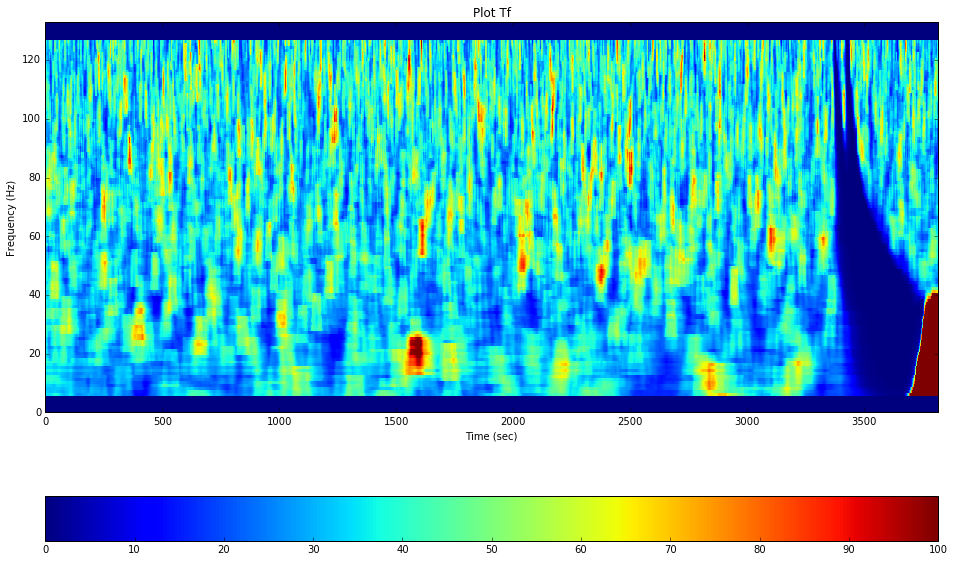

(133, 3816)


1240.2607913994066

In [27]:
array = getData('gun')
array = array['Tf']

fig = plt.figure(figsize=(16,10,))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(array, interpolation='nearest',aspect='auto', vmin = 0, vmax=100)
plt.title('Plot Tf')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(img, orientation='horizontal')
plt.ylim(0, 133) #Flipping Y so that 0 is at the bottom
plt.show()

#tijd is X, freq is Y, color is intensity van 0 tot 100 dB²
print array.shape
array[20][3800]

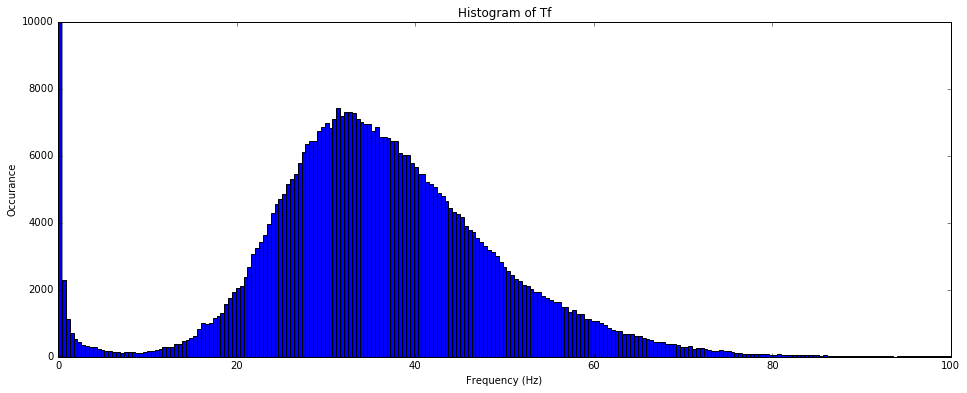

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,6,))
ax = fig.add_subplot(1,1,1)
plt.hist(array.ravel(), bins='auto', range=(0, 100))#Ravel makes a 1D array from a 2D, {{1,2}, {3,4}} = {1,2,3,4}
plt.title('Histogram of Tf')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Occurance')
plt.ylim(0, 10000)
plt.show()


# Analyzing data
scipy return D+ (could get D+ and D-).
Scipy expects a 1D array, should I split our 2D array up into 1D arrays and add them into one big array?

In [4]:
from scipy import stats

array = getData('gun')
array = array['Tf']
arrayDistance = np.zeros(len(array))
print array.shape 
print arrayDistance.shape
i = 0
for x in array:
    arrayDistance[i] = stats.kstest(x, 'norm')[0]
    i+=1
arrayDistance

(133, 3816)
(133,)


array([ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.96638255,  0.95856372,  0.95412675,  0.9477583 ,
        0.94737324,  0.94664959,  0.94387401,  0.94002355,  0.94047926,
        0.93969476,  0.93620021,  0.93827434,  0.93616117,  0.93360254,
        0.93229598,  0.9317228 ,  0.93283617,  0.93156667,  0.93043443,
        0.9294811 ,  0.92919912,  0.92780387,  0.92784368,  0.92725325,
        0.92372456,  0.92333781,  0.92334276,  0.92209528,  0.92174207,
        0.91694092,  0.91612938,  0.91526536,  0.91457677,  0.92184094,
        0.92234977,  0.92482237,  0.92457882,  0.92374303,  0.92828911,
        0.92816828,  0.92943443,  0.93379308,  0.93343657,  0.93880979,
        0.93988364,  0.94118978,  0.94304317,  0.94467866,  0.94732841,
        0.94696991,  0.94718267,  0.9485176 ,  0.95206701,  0.95194936,
        0.95215649,  0.95349985,  0.95616044,  0.95692437,  0.95917996,
        0.96134403,  0.96230137,  0.96372461,  0.96473654,  0.96